In [109]:
import numpy as np
import tensorflow as tf

### 데이터 불러오기

In [110]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [111]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [112]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [113]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [114]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [115]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [116]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

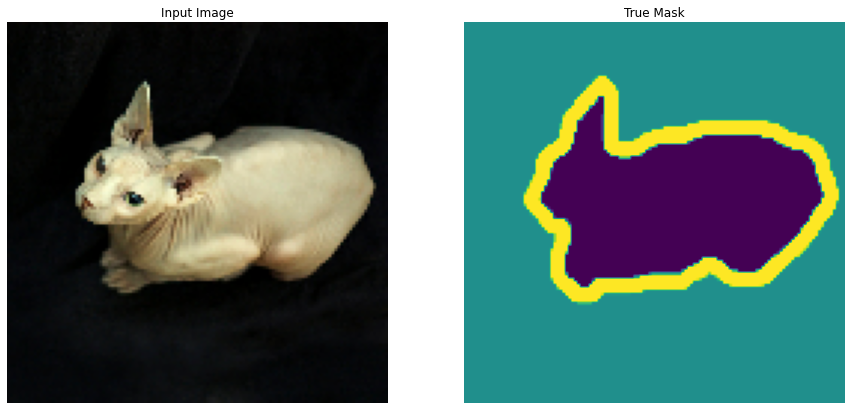

In [117]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

### U-net 생성

In [118]:
import tensorflow as tf

In [119]:
input_layer = tf.keras.layers.Input(shape=[128, 128, 3])

conv_layer1_1 = tf.keras.layers.Conv2D(64, kernel_size=3, padding = 'same', activation='relu')(input_layer)
conv_layer1_2 = tf.keras.layers.Conv2D(64, kernel_size=3, padding = 'same', activation='relu')(conv_layer1_1)
pooling_layer1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_layer1_2) # (None, 64, 64, 64)

conv_layer2_1 = tf.keras.layers.Conv2D(128, kernel_size=3, padding = 'same', activation='relu')(pooling_layer1)
conv_layer2_2 = tf.keras.layers.Conv2D(128, kernel_size=3, padding = 'same', activation='relu')(conv_layer2_1)
pooling_layer2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_layer2_2) # (None, 32, 32, 128)

conv_layer3_1 = tf.keras.layers.Conv2D(256, kernel_size=3, padding = 'same', activation='relu')(pooling_layer2)
conv_layer3_2 = tf.keras.layers.Conv2D(256, kernel_size=3, padding = 'same', activation='relu')(conv_layer3_1)
pooling_layer3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_layer3_2) # (None, 16, 16, 256)

conv_layer4_1 = tf.keras.layers.Conv2D(512, kernel_size=3, padding = 'same', activation='relu')(pooling_layer3)
conv_layer4_2 = tf.keras.layers.Conv2D(512, kernel_size=3, padding = 'same', activation='relu')(conv_layer4_1) # (None, 8, 8, 512)
pooling_layer4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_layer4_2)

conv_layer5_1 = tf.keras.layers.Conv2D(1024, kernel_size=3, padding = 'same', activation='relu')(pooling_layer4)
conv_layer5_2 = tf.keras.layers.Conv2D(1024, kernel_size=3, padding = 'same', activation='relu')(conv_layer5_1) # (None, 4, 4, 1024)

deconv_layer4 = tf.keras.layers.Conv2DTranspose(512, 2, strides=(2,2), padding='same')(conv_layer5_2) # (None, 8, 8, 512)
concated_layer4 = tf.concat([conv_layer4_2,deconv_layer4], -1) # (None, 8, 8, 1024)

concat_conv_layer4_1 =  tf.keras.layers.Conv2D(512, kernel_size=3, padding = 'same', activation='relu')(concated_layer4)
concat_conv_layer4_2 =  tf.keras.layers.Conv2D(512, kernel_size=3, padding = 'same', activation='relu')(concat_conv_layer4_1) # (None, 8, 8, 512)

deconv_layer3 = tf.keras.layers.Conv2DTranspose(256, 2, padding='same', strides=(2,2))(concat_conv_layer4_2) # (None, 104, 104, 256)
concated_layer3 = tf.concat([conv_layer3_2, deconv_layer3],-1) # (None, 56, 56, 512)

concat_conv_layer3_1 =  tf.keras.layers.Conv2D(256, kernel_size=3, padding = 'same', activation='relu')(concated_layer3)
concat_conv_layer3_2 =  tf.keras.layers.Conv2D(256, kernel_size=3, padding = 'same', activation='relu')(concat_conv_layer3_1) # (None, 100, 100, 256)

deconv_layer2 = tf.keras.layers.Conv2DTranspose(128, 2, padding='same', strides=(2,2))(concat_conv_layer3_2)
concated_layer2 = tf.concat([conv_layer2_2, deconv_layer2],-1) # (None, 56, 56, 512)

concat_conv_layer2_1 =  tf.keras.layers.Conv2D(128, kernel_size=3, padding = 'same', activation='relu')(concated_layer2)
concat_conv_layer2_2 =  tf.keras.layers.Conv2D(128, kernel_size=3, padding = 'same', activation='relu')(concat_conv_layer2_1) # (None, 100, 100, 256)

deconv_layer1 = tf.keras.layers.Conv2DTranspose(64, 2, padding='same', strides=(2,2))(concat_conv_layer2_2)
concated_layer1 = tf.concat([conv_layer1_2, deconv_layer1],-1) # (None, 56, 56, 512)

concat_conv_layer1_1 =  tf.keras.layers.Conv2D(64, kernel_size=3, padding = 'same', activation='relu')(concated_layer1)
concat_conv_layer1_2 =  tf.keras.layers.Conv2D(64, kernel_size=3, padding = 'same', activation='relu')(concat_conv_layer1_1)

output_layer = tf.keras.layers.Conv2D(3, kernel_size=1, padding = 'valid')(concat_conv_layer1_2)
print("output :", output_layer.shape)

output : (None, 128, 128, 3)


In [120]:
Unet = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [121]:
Unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [122]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [123]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(Unet.predict(sample_image[tf.newaxis, ...]))])

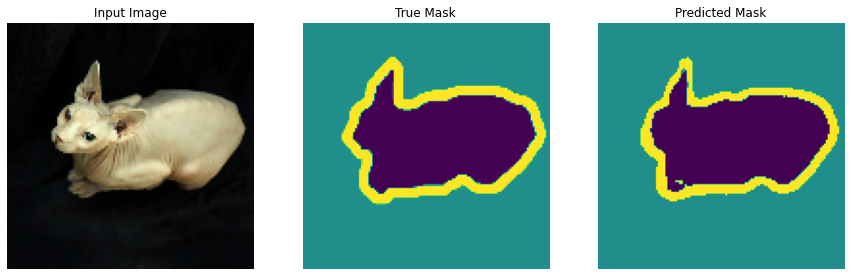

In [124]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()

model_history = Unet.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

외부에서 가져온 고양이 사진으로 테스트

In [132]:
test_img = plt.imread('./cat.jpg')

In [133]:
tensor = tf.cast(test_img, tf.float32) / 255.0
tensor = tf.image.resize(tensor, (128, 128))
input_tensor = tf.expand_dims(tensor, axis=0)


In [134]:
prediction = Unet.predict(input_tensor)
predicted_mask = create_mask(prediction)

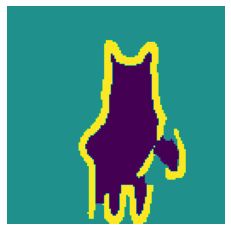

In [135]:
plt.axis("off")
plt.imshow(predicted_mask)